> Copyright 2022 University of Luxembourg
> 
> Licensed under the Apache License, Version 2.0 (the "License");  
> you may not use this file except in compliance with the License.  
> You may obtain a copy of the License at  
>
>    https://www.apache.org/licenses/LICENSE-2.0
>
> Unless required by applicable law or agreed to in writing, software  
> distributed under the License is distributed on an "AS IS" BASIS,  
> WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
> See the License for the specific language governing permissions and  
> limitations under the License.  
>
***

Author: André Stemper (andre.stemper@uni.lu)

***

# Postprocessing - Aggregate informations from multiple experiments


Measurement results directory


In [1]:
measurements_root = './measurements'


In [2]:
import math
import json
import sys
import pickle
import time
import datetime
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline


In [3]:
aggregated_data = {}


Append data from one experiment located in measurements_directory


In [4]:
def append_experiment(measurement, measurements_directory, verbose=False):
    global aggregated_data
    # load settings
    try:
        filename = measurements_directory + os.path.sep + 'settings.json'
        with open(filename, 'r') as file:
            settings = json.load(file)
            print("{}>Settings loaded from '{}'".format(measurement, filename))
        if verbose:
            print('{}>Settings:'.format(measurement))
            for k, v in settings.items():
                print(" - {} = {}".format(k, v))
    except Exception as e:
        print("{}>!!! Missing settings: {}".format(measurement, e))
        print("{}>!!! Aborting".format(measurement))
        return
    # load power statistics
    try:
        filename = measurements_directory + os.path.sep + 'power_statistics.json'
        with open(filename, 'r') as file:
            power_statistics = json.load(file)
            print("{}>Power statistics loaded from '{}'".format(
                measurement, filename))
        if verbose:
            print('{}>Power statistics:'.format(measurement))
            for k, v in power_statistics.items():
                print(" - {} = {}".format(k, v))
    except Exception as e:
        print("{}>!!! Missing power statistics: {}".format(measurement, e))
        power_statistics['experiment']['mean'] = -1
        power_statistics['experiment']['std'] = -1
        power_statistics['background']['mean'] = -1
        power_statistics['background']['std'] = -1
        power_statistics['difference']['mean'] = -1
        power_statistics['difference']['std'] = -1

    # load timing statistics
    try:
        filename = measurements_directory + os.path.sep + 'execution_time_statistics.json'
        with open(filename, 'r') as file:
            execution_time_statistics = json.load(file)
            print("{}>Execution time statistics loaded from '{}'".format(
                measurement, filename))
        if verbose:
            print('{}>Execution time statistics:'.format(measurement))
            for k, v in execution_time_statistics.items():
                print(" - {} = {}".format(k, v))
    except Exception as e:
        print("{}>!!! Missing execution time statistics: {}".format(measurement, e))

    # aggregate into dict
    row = {'experiment': settings['timestamp'],
           'dataset': settings['dataset'],
           'range': settings['range'],
           'frequency': float(settings['frequency']),
           'connection_type': settings['connection_type'],
           'limit': settings['limit'],
           'threshold_hold_off': int(settings['threshold_hold_off']),
           'power_experiment_mean': power_statistics['experiment']['mean'],
           'power_experiment_std': power_statistics['experiment']['std'],
           'power_background_mean': power_statistics['background']['mean'],
           'power_background_std': power_statistics['background']['std'],
           'power_difference_mean': power_statistics['difference']['mean'],
           'power_difference_std': power_statistics['difference']['std'],
           'execution_time_mean': execution_time_statistics['execution_time']['mean'],
           'execution_time_median': execution_time_statistics['execution_time']['median'],
           'execution_time_std': execution_time_statistics['execution_time']['std']
           }
    aggregated_data[settings['timestamp']] = row


Aggregate from all experiments


In [5]:
import os
for file in os.listdir(measurements_root):
    d = os.path.join(measurements_root, file)
    if os.path.isdir(d):
        if file in ['timings', 'histograms']:
            continue
        experiment_timestamp_string = file
        append_experiment(experiment_timestamp_string, d)
        print("---")


20221024-082511>Settings loaded from './measurements/20221024-082511/settings.json'
20221024-082511>Power statistics loaded from './measurements/20221024-082511/power_statistics.json'
20221024-082511>Execution time statistics loaded from './measurements/20221024-082511/execution_time_statistics.json'
---
20221021-102531>Settings loaded from './measurements/20221021-102531/settings.json'
20221021-102531>Power statistics loaded from './measurements/20221021-102531/power_statistics.json'
20221021-102531>Execution time statistics loaded from './measurements/20221021-102531/execution_time_statistics.json'
---
20221024-130021>Settings loaded from './measurements/20221024-130021/settings.json'
20221024-130021>Power statistics loaded from './measurements/20221024-130021/power_statistics.json'
20221024-130021>Execution time statistics loaded from './measurements/20221024-130021/execution_time_statistics.json'
---
20221024-093322>Settings loaded from './measurements/20221024-093322/settings.json

**convert into a dataframe**


In [6]:
aggregated_dataframe = pd.DataFrame.from_dict(aggregated_data, orient='index')
filename = measurements_root + os.path.sep + "aggregated.csv"
aggregated_dataframe.to_csv(filename, sep=';')


## Power difference vs Clock frequency


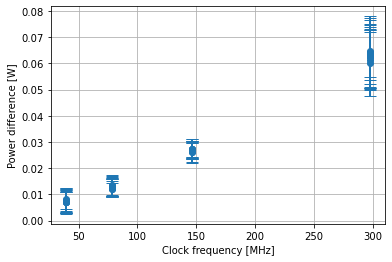

In [7]:

#filtered = aggregated_dataframe[(aggregated_dataframe['dataset'] == '2022.06.15') &
#                                (aggregated_dataframe['connection_type'] == 'remote')]

filtered = aggregated_dataframe
filtered = filtered.sort_values(by=['frequency'])


fig, ax = plt.subplots(nrows=1, sharex=True)
ax.errorbar(filtered['frequency'], filtered['power_difference_mean'],
            yerr=filtered['power_difference_std'], fmt='o', linewidth=2, capsize=6)
ax.set_xlabel('Clock frequency [MHz]')
ax.set_ylabel('Power difference [W]')
plt.grid()


filename = measurements_root + os.path.sep + "power_vs_clock_frequency.png"
plt.savefig(filename)
filename = measurements_root + os.path.sep + "power_vs_clock_frequency.pdf"
plt.savefig(filename)


## Power difference vs Experiment


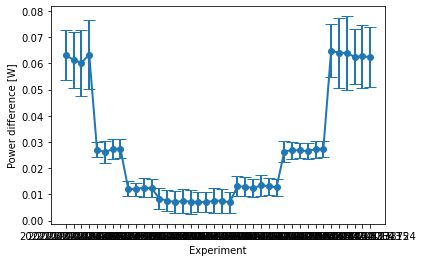

In [8]:

filtered = aggregated_dataframe
filtered = filtered.sort_values(by=['experiment'])

fig, ax = plt.subplots(nrows=1, sharex=True)
ax.errorbar(filtered['experiment'], filtered['power_difference_mean'],
            yerr=filtered['power_difference_std'], fmt='-o', linewidth=2, capsize=6)
ax.set_xlabel('Experiment')
ax.set_ylabel('Power difference [W]')

filename = measurements_root + os.path.sep + "power_vs_experiment.png"
plt.savefig(filename)
filename = measurements_root + os.path.sep + "power_vs_experiment.pdf"
plt.savefig(filename)


## Execution time vs Clock Frequency


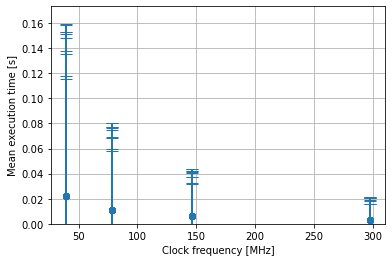

In [9]:

filtered = aggregated_dataframe
filtered = filtered.sort_values(by=['frequency'])


fig, ax = plt.subplots(nrows=1, sharex=True)
ax.errorbar(filtered['frequency'], filtered['execution_time_mean'],
            yerr=filtered['execution_time_std'], fmt='o', linewidth=2, capsize=6)
ax.set_xlabel('Clock frequency [MHz]')
ax.set_ylabel('Mean execution time [s]')
ax.set_ylim(0, None)
plt.grid()

filename = measurements_root + os.path.sep + "execution_time_vs_clock_frequency.png"
plt.savefig(filename)
filename = measurements_root + os.path.sep + "execution_time_vs_clock_frequency.pdf"
plt.savefig(filename)



TODO barplot with errros 

In [10]:
experiment_datasets =['2022.04.06', '2022.05.18', '2022.05.20', '2022.05.30', '2022.06.01', '2022.06.03', '2022.06.08', '2022.06.15', '2022.06.22', '2022.07.20']
experiment_clock_frequencies = [39,78,146,298]

box and whisker plot 
or min,max, mean

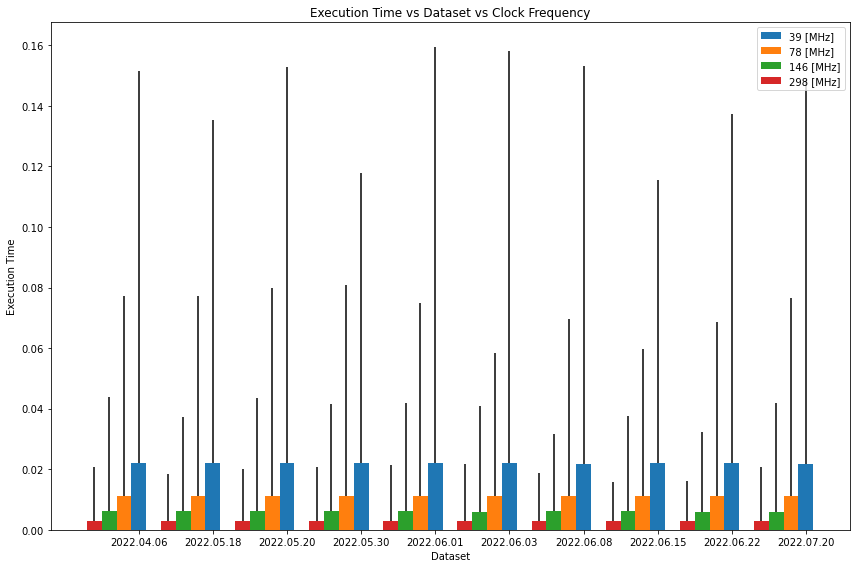

In [11]:
filtered = aggregated_dataframe
filtered = filtered.sort_values(by=['frequency'])

ind = np.arange(len(experiment_datasets))  # the x locations for the groups
width = 0.20  # the width of the bars
amp = 1


fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
rects = {}
for i, f in enumerate(experiment_clock_frequencies):
    t = filtered[(filtered['frequency'] == f)]
    if len(t) == 0:
        raise Exception("Not enough data")
    rects[f] = ax.bar(ind*amp - amp*i*width,
                      t['execution_time_mean'],
                      width,
                      yerr=(np.zeros(len(t['execution_time_std'])),
                            t['execution_time_std']),
                      label="{} [MHz]".format(f),
                      log=False)  # t['execution_time_std']

ax.set_ylabel('Execution Time')
ax.set_xlabel('Dataset')
ax.set_title('Execution Time vs Dataset vs Clock Frequency')
ax.set_xticks(ind)
ax.set_xticklabels(["{}".format(f) for f in experiment_datasets])
ax.legend()

fig.tight_layout()

filename = measurements_root + os.path.sep + "execution_time_vs_dataset_vs_clock_frequency.png"
plt.savefig(filename)
filename = measurements_root + os.path.sep + "execution_time_vs_dataset_clock_frequency.pdf"
plt.savefig(filename)

plt.show()
